In [1]:
import os
import csv
import obspy


cwd = os.getcwd()
DATA_PATH = f'{cwd}/kik_knet_data'
ALL_DATA_PATH = f'{DATA_PATH}/all_data'
RAW_DATA_PATH = f'{ALL_DATA_PATH}/selecteddata'

In [2]:
event_folders = os.listdir(RAW_DATA_PATH)
folder_files = {}
for folder_name in event_folders:
    folder_path = f'{RAW_DATA_PATH}/{folder_name}'
    files = os.listdir(folder_path)
    folder_files[folder_name] = [
        f'{folder_path}/{file_name}' \
        for file_name in files if '.ps' not in file_name
    ]


In [3]:
from obspy.core import Stream
def get_event_streams(event_name):
    st = Stream()
    files_paths = folder_files[event_name]
    for file_path in files_paths:
        st += obspy.read(file_path, format="knet", apply_calib=True)
        trace = st[0]
        # skipping stations with 200Hz sampling rate
        if trace.stats.sampling_rate == 200:
            return None
    return st

In [4]:
events_streams = {}
for event_name in event_folders:
    streams = get_event_streams(event_name)
    if streams is None: continue
    events_streams[event_name] = streams


In [20]:
import pickle
def save_streams(name, data):
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

def load_streams(name):
    with open(f'{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

In [6]:
# save_streams('all_events_streams', events_streams)

In [7]:
events_streams = load_streams('all_events_streams')

In [8]:
from obspy.signal.trigger import ar_pick
def find_pswave_onset(data):
    df = data[0].stats.sampling_rate
    p_pick, s_pick = ar_pick(data[0].data, data[1].data, data[2].data, df,
                            1.0, 20.0, 1.0, 0.1, 4.0, 1.0, 2, 8, 0.1, 0.2)
    return (p_pick, s_pick)

In [9]:
from obspy.core import Stream
ONE_SEC = 1
def extract_one_sec_of_pwave(pstart, stream):
    one_sec_pwave_stream = Stream()
    for tr in stream:
        dt = tr.stats.delta
        starttime = stream[0].stats.starttime
        pstarttime = starttime + pstart
        one_sec_pwave_stream += tr.slice(pstarttime, pstarttime + ONE_SEC - dt)
    return one_sec_pwave_stream

In [10]:
from obspy.core import Stream

considered_channels = ['NS2', 'EW2', 'UD2']
one_sec_pwave_events_streams = {}
filtered_one_sec_pwave_events_streams = {}
for event in events_streams:
    data = events_streams[event]
    if len(data) == 6:
        st = Stream()
        for trace in data:
            if trace.stats.channel not in considered_channels: continue
            st += trace
        data = st
    pw_onset, sw_onset = find_pswave_onset(data)
    one_sec_pwave_events_streams[event] = extract_one_sec_of_pwave(pw_onset, data)
    filtered_one_sec_pwave_events_streams[event] = \
        extract_one_sec_of_pwave(pw_onset, data).filter('bandpass', freqmin=10, freqmax=20)

# save_streams('one_sec_pwave_events_streams', one_sec_pwave_events_streams)
# save_streams('filtered_one_sec_pwave_events_streams', filtered_one_sec_pwave_events_streams)

In [16]:
import numpy as np
def create_ss_waveform_data(stream):
    matrix = np.array([tr.data for tr in stream])
    return np.sqrt(np.sum(np.square(matrix), axis=0))

In [17]:
geo_means = {}
for event in one_sec_pwave_events_streams:
    st = one_sec_pwave_events_streams[event]
    geo_mean = create_ss_waveform_data(st)
    geo_means[event] = geo_mean

save_streams('one_sec_geo_means', geo_means)

In [11]:
import numpy as np
from obspy.core import Stream
def create_absolute_stream(stream):
    abs_traces = []
    for tr in stream:
        abs_trace = tr.copy()
        abs_trace.data = np.abs(tr.data)
        abs_traces.append(abs_trace)
    return Stream(traces=abs_traces)

In [12]:
abs_one_sec_pwave_events_streams = {}
for event in one_sec_pwave_events_streams:
    st = one_sec_pwave_events_streams[event]
    one_sec_abs_pwave_stream = create_absolute_stream(st)
    abs_one_sec_pwave_events_streams[event] = one_sec_abs_pwave_stream

save_streams('abs_one_sec_pwave_events_streams', abs_one_sec_pwave_events_streams)

In [13]:
import numpy as np
from obspy.core import Stream
def create_cumabs_stream(abs_stream):
    cumabs_traces = []
    for tr in abs_stream:
        cumabs_trace = tr.copy()
        cumabs_trace.data = np.cumsum(tr.data)
        cumabs_traces.append(cumabs_trace)
    return Stream(traces=cumabs_traces)

In [14]:
cumabs_one_sec_pwave_events_streams = {}
for event in abs_one_sec_pwave_events_streams:
    st = abs_one_sec_pwave_events_streams[event]
    one_sec_cumabs_pwave_stream = create_cumabs_stream(st)
    cumabs_one_sec_pwave_events_streams[event] = one_sec_cumabs_pwave_stream

save_streams('cumabs_one_sec_pwave_events_streams', cumabs_one_sec_pwave_events_streams)

## create plots for near source: TCGH071212171848
## create plots for far source: TKCH081208252316

In [1]:
# load onesec pwave data here, if not available
import pickle
def load_streams(name):
    with open(f'{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

all_events_streams = load_streams('all_events_streams')
one_sec_pwave_events_streams = load_streams('one_sec_pwave_events_streams')
filtered_one_sec_pwave_events_streams = load_streams('filtered_one_sec_pwave_events_streams')
abs_one_sec_pwave_events_streams = load_streams('abs_one_sec_pwave_events_streams')
cumabs_one_sec_pwave_events_streams = load_streams('cumabs_one_sec_pwave_events_streams')
geo_means = load_streams('one_sec_geo_means')

In [2]:
def create_station_dict(station_name, normalize=False):
    all = all_events_streams[station_name].copy()
    one_sec_acc = one_sec_pwave_events_streams[station_name].copy()
    one_sec_filt = filtered_one_sec_pwave_events_streams[station_name].copy()
    one_sec_abs = abs_one_sec_pwave_events_streams[station_name].copy()
    one_sec_cumabs = cumabs_one_sec_pwave_events_streams[station_name].copy()

    one_sec_acc = one_sec_acc.normalize() if normalize else one_sec_acc
    one_sec_filt = one_sec_filt.normalize() if normalize else one_sec_filt
    one_sec_abs = one_sec_abs.normalize() if normalize else one_sec_abs
    one_sec_cumabs = one_sec_cumabs.normalize() if normalize else one_sec_cumabs

    return {
        'all_time_acc': all,
        'one_sec_acc': one_sec_acc,
        'one_sec_filt_acc': one_sec_filt,
        'one_sec_abs_acc': one_sec_abs,
        'one_sec_cumabs_acc': one_sec_cumabs,
    }

In [3]:
# Where to save the figures
import os
PROJECT_ROOT_DIR = "."
NAME = "kik_knet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", NAME)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_features(near, far, figname):
    figure, axis = plt.subplots(4, 3, figsize=(15,15))

    FEATURES = ['Acc', 'Filt', 'Abs', 'CumAbs']
    COMPONENTS = ['EW', 'NS', 'UD']
    FEATURES_DATA_MAP = {
        'Acc': 'one_sec_acc',
        'Filt': 'one_sec_filt_acc',
        'Abs': 'one_sec_abs_acc',
        'CumAbs': 'one_sec_cumabs_acc'
    }

    x = np.array([i for i in range(100)])
    for row, feature in enumerate(FEATURES):
        for col, comp in enumerate(COMPONENTS):
            near_stream = near[FEATURES_DATA_MAP[feature]]
            far_stream = far[FEATURES_DATA_MAP[feature]]
            for ntrace, ftrace in zip(near_stream, far_stream):
                nchannel, fchannel = ntrace.stats.channel[:2], ftrace.stats.channel[:2]
                if nchannel == comp:
                    axis[row, col].plot(x, ntrace.data, color='b')
                if fchannel == comp:
                    axis[row, col].plot(x, ftrace.data, color='r')
            axis[row, col].set_title(f'{feature} {comp}')
    # save_fig(figname)
    plt.show()


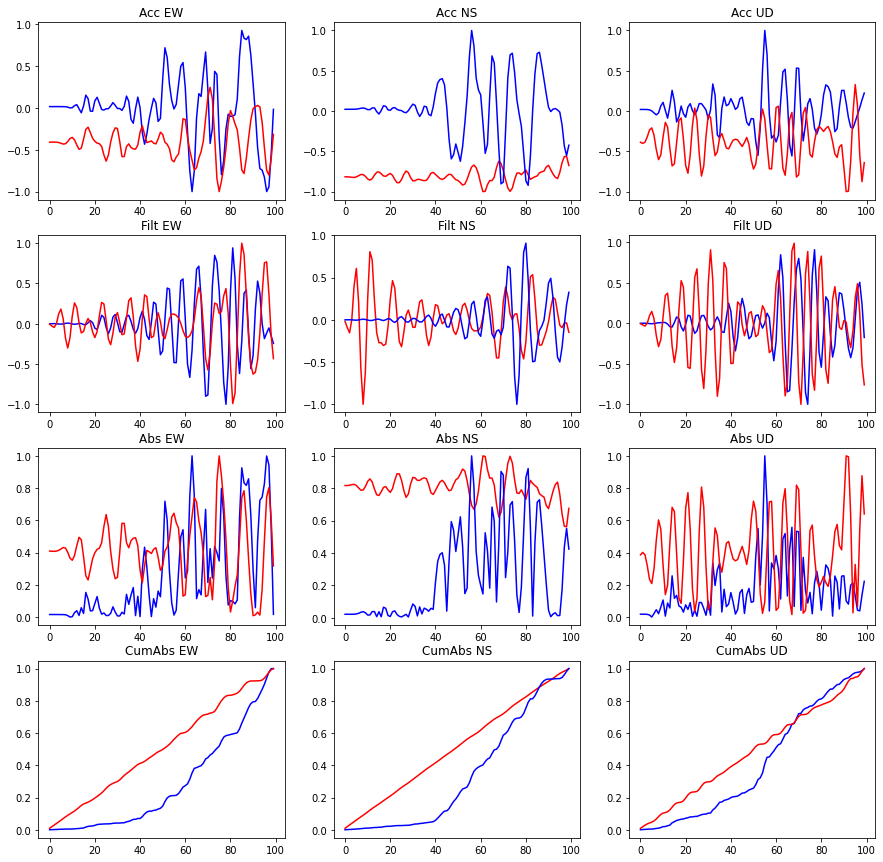

In [5]:
norm_near = create_station_dict('TCGH071212171848', True)
norm_far = create_station_dict('TKCH081208252316', True)
plot_all_features(norm_near, norm_far, "normalized_all_feature_plot_with_obspy")

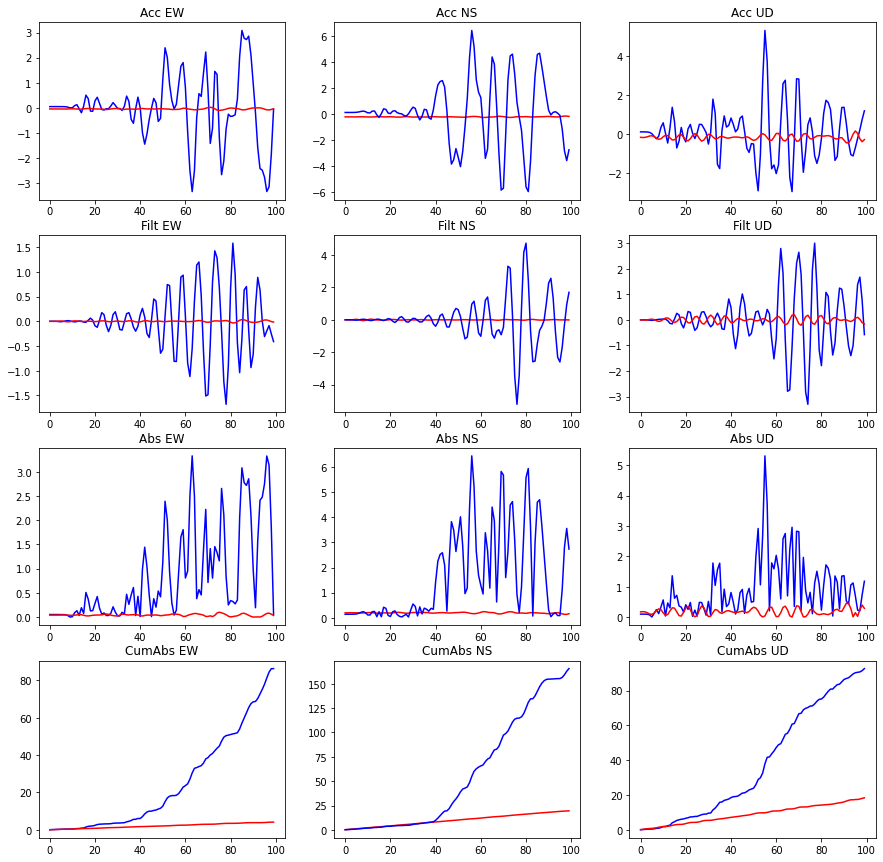

In [6]:
near = create_station_dict('TCGH071212171848', False)
far = create_station_dict('TKCH081208252316', False)
plot_all_features(near, far, "notnormalized_all_feature_plot_with_obspy")

## ML

In [18]:
def get_input_matrix(station_name):
    """ return 13 x 100 matrix """

    data = create_station_dict(station_name, True)
    mega_features = [
        'one_sec_acc',
        'one_sec_filt_acc',
        'one_sec_abs_acc',
        'one_sec_cumabs_acc'
    ]

    input_matrix = []
    for mfeat in mega_features:
        stream = data[mfeat]
        for tr in stream:
            input_matrix.append(tr.data.tolist())

    # add geomean normalised waveform to feature
    geo_mean = geo_means[station_name]
    scaled_geo_mean = geo_mean / float(np.max(geo_mean))
    input_matrix.append(scaled_geo_mean.tolist())

    return input_matrix

def get_output_matrix(station_name):
    """ return vec of size 13 """
    #  NEAR SOURCE: 1
    #  FAR  SOURCE: 0

    data = create_station_dict(station_name, True)
    stream = data['one_sec_acc']
    trace = stream[0]
    depth = trace.stats.knet.evdp
    is_near_source = int(depth < 17)
    return [is_near_source for _ in range(13)]

In [21]:
X, y = [], []
for station in one_sec_pwave_events_streams:
    inp = get_input_matrix(station)
    outp = get_output_matrix(station)
    X.extend(inp)
    y.extend(outp)
data = {'X': X, 'y':y}
save_streams('ML_DATA', data)

In [22]:
## split array into test and train
import numpy as np
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# train_data = {'X_train': X_train, 'y_train': y_train}
# test_data = {'X_test': X_test, 'y_test': y_test}
# save_streams('TEST_DATA', test_data)
# save_streams('TRAIN_DATA', train_data)

In [18]:
import pickle
def load_streams(name):
    with open(f'{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

train_data = load_streams('TRAIN_DATA')
test_data = load_streams('TEST_DATA')
X_train, y_train = train_data['X_train'], train_data['y_train']
X_test, y_test = test_data['X_test'], ['y_test']

In [19]:
import numpy
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
numpy.random.seed(42)

In [20]:
print(y_train)

[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 

In [22]:
# create the model
input_dim = 1341
output_dim = 100
input_len = 100
model = Sequential()
model.add(tf.keras.layers.Embedding(input_dim, output_dim, input_length=input_len))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=67)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          134100    
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 214,601
Trainable params: 214,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_5/embedding_5/embedding_lookup' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/adebowale/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/adebowale/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/adebowale/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/adebowale/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/adebowale/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/adebowale/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/adebowale/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/adebowale/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/adebowale/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/adebowale/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/home/adebowale/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/home/adebowale/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/adebowale/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/adebowale/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/adebowale/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3122/541470575.py", line 11, in <cell line: 11>
      model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=67)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/adebowale/.local/lib/python3.8/site-packages/keras/layers/core/embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_5/embedding_5/embedding_lookup'
indices[14,98] = -1 is not in [0, 1341)
	 [[{{node sequential_5/embedding_5/embedding_lookup}}]] [Op:__inference_train_function_8437]